In [71]:
import numpy as np
import pandas as pd
import tensorflow as tf
from google.colab import files
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf

In [72]:
dataset = files.upload()
filename = list(dataset.keys())[0]

Saving PKO.WA (2004-2023).csv to PKO.WA (2004-2023) (1).csv


In [73]:
df = pd.read_csv(filename)

In [74]:
df = df.dropna(how='any',axis=0)

In [75]:
df = df[['Date', 'Close']]

In [76]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)


In [77]:
df['Date'] = df['Date'].apply(str_to_datetime)

In [78]:
df.index = df.pop('Date')

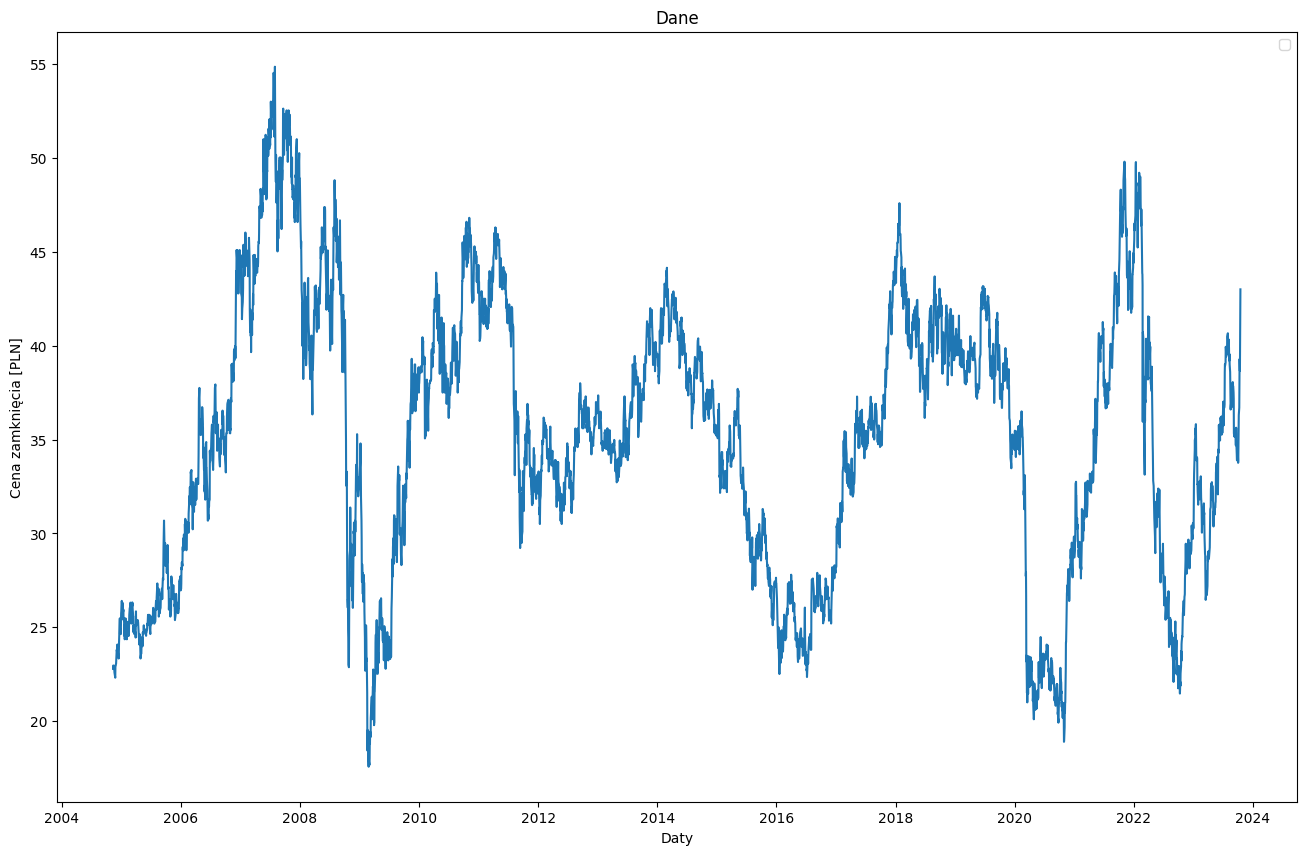

In [79]:
plt.figure(figsize=(16,10))
plt.plot(df.index, df['Close'])
plt.title('Dane')
plt.xlabel('Daty')
plt.ylabel('Cena zamknięcia [PLN]')
plt.legend()

In [85]:
def df_to_windowed_df(dateframe, first_date_str, last_date_str, n):
  first_date = str_to_datetime(first_date_str)
  last_date = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dateframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dateframe.loc[target_date:target_date + datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df


start = df['Close'].index[n]
start_date = start.strftime('%Y-%m-%d')

end = df['Close'].index[-1]
end_date = end.strftime('%Y-%m-%d')

n = 1

windowed_df = df_to_windowed_df(df, start_date, end_date, n)


In [81]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1: -1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((4869,), (4869, 1, 1), (4869,))

In [82]:
blue_color = (0.2, 0.4, 0.6);
green_color = (0.4, 0.7, 0.2);
red_color = (0.8, 0.2, 0.4);

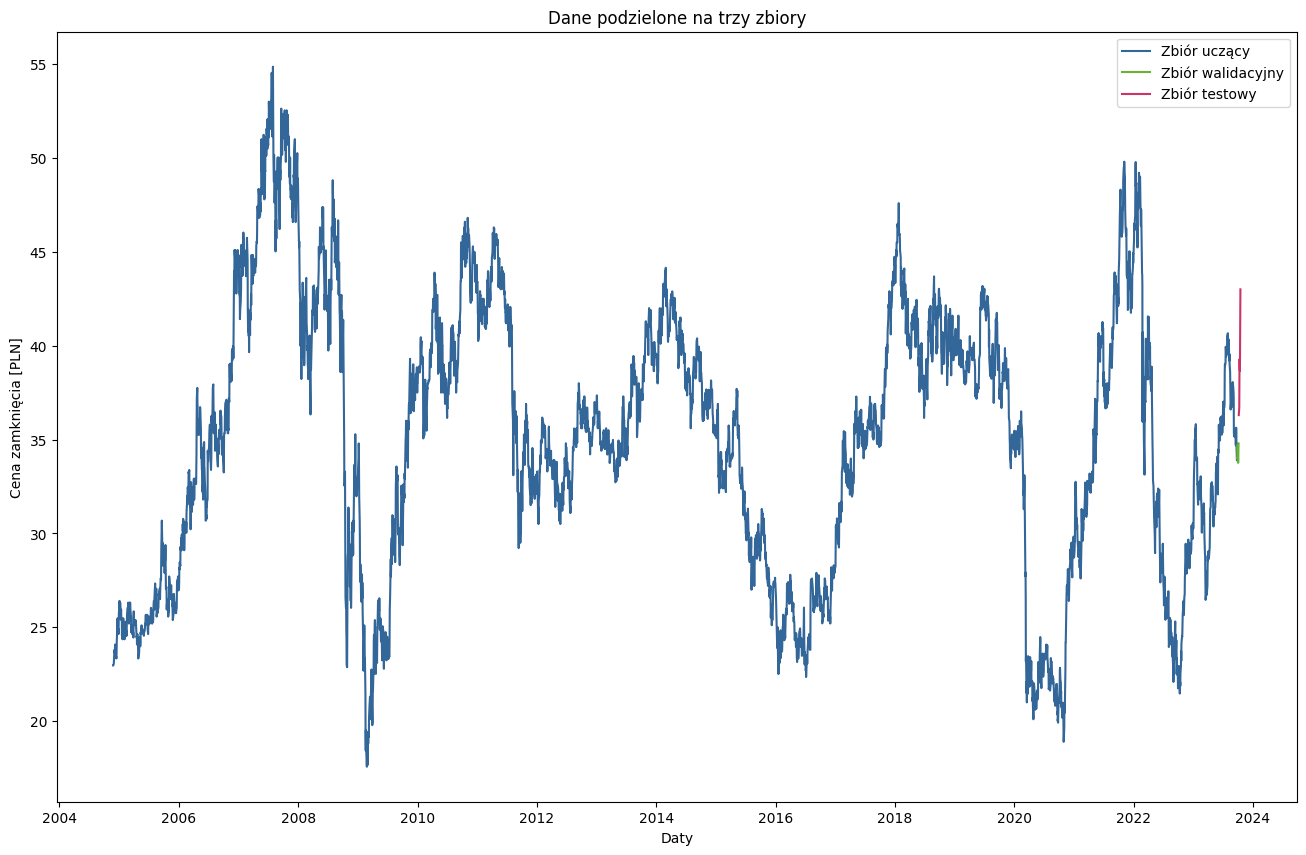

In [83]:
q_80 = int(len(dates) * 0.6)
q_90 = int(len(dates) * 0.8)

# dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

# dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]

# dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

size_of_set = 7

a = int(len(dates) - size_of_set * 2)
b = int(len(dates) - size_of_set)

dates_train, X_train, y_train = dates[:a], X[:a], y[:a]

dates_val, X_val, y_val = dates[a:b], X[a:b], y[a:b]

dates_test, X_test, y_test = dates[b:], X[b:], y[b:]

plt.figure(figsize=(16,10))
plt.plot(dates_train, y_train, color=blue_color)
plt.plot(dates_val, y_val, color=green_color)
plt.plot(dates_test, y_test, color=red_color)
plt.title('Dane podzielone na trzy zbiory')
plt.xlabel('Daty')
plt.ylabel('Cena zamknięcia [PLN]')

plt.legend(['Zbiór uczący', 'Zbiór walidacyjny', 'Zbiór testowy'])

## Funkcje pomocnicze do obliczania błędów

In [55]:
def calculate_mse(actual, predicted):
    return np.square(np.subtract(np.array(actual), np.array(predicted)))

def calculate_mae(actual_values, predicted_values):
    return np.abs(np.array(actual_values) - np.array(predicted_values))

def mape(Y_actual,Y_Predicted):
    return np.mean(np.abs((Y_actual - Y_Predicted) / Y_actual)) * 100

# Funkcje pomocnicze do wyświetlania wykresów

In [56]:
def display_error_figure(data, title):
  plt.figure(figsize=(12,8))
  plt.plot(data, color=blue_color)
  plt.title(title)
  plt.ylabel('Wartość błędu')
  plt.xlabel('Obserwacje')
  plt.show()

def display_error_boxplot(data, title):
  plt.figure(figsize=(12,8))
  plt.boxplot(data)
  plt.title(title)
  plt.ylabel('Wartość błędu')
  plt.xlabel('')
  plt.show()

def display_prediction_data(dates, predictions, actual, title):
  plt.figure(figsize=(12,8))
  plt.plot(dates, actual, color=green_color)
  plt.plot(dates, predictions, color=blue_color)
  plt.legend(['Rzeczywsite', 'Przewidywane'])
  plt.xlabel('Daty')
  plt.ylabel('Cena zamknięcia [PLN]')
  plt.title(title)
  plt.show()

# Sieć neuronowa

In [86]:
import tensorflow as tf

model = tf.keras.models.Sequential([tf.keras.layers.Input((n, 1)),
                                    tf.keras.layers.LSTM(32),
                                    tf.keras.layers.Dense(16, activation='relu'),
                                    tf.keras.layers.Dense(16, activation='relu'),
                                    tf.keras.layers.Dense(48, activation='relu'),
                                    tf.keras.layers.Dense(1)])

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['mean_absolute_error', 'mean_squared_error'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

Epoch 1/20
152/152 [==============================] - 5s 7ms/step - loss: 588.7180 - mean_absolute_error: 19.8989 - mean_squared_error: 588.7180 - val_loss: 1.2992 - val_mean_absolute_error: 1.0603 - val_mean_squared_error: 1.2992
Epoch 2/20
152/152 [==============================] - 1s 4ms/step - loss: 8.6203 - mean_absolute_error: 1.9522 - mean_squared_error: 8.6203 - val_loss: 0.6142 - val_mean_absolute_error: 0.6229 - val_mean_squared_error: 0.6142
Epoch 3/20
152/152 [==============================] - 1s 4ms/step - loss: 1.2867 - mean_absolute_error: 0.8534 - mean_squared_error: 1.2867 - val_loss: 1.0631 - val_mean_absolute_error: 0.8268 - val_mean_squared_error: 1.0631
Epoch 4/20
152/152 [==============================] - 1s 4ms/step - loss: 1.0629 - mean_absolute_error: 0.7751 - mean_squared_error: 1.0629 - val_loss: 1.4827 - val_mean_absolute_error: 1.0488 - val_mean_squared_error: 1.4827
Epoch 5/20
152/152 [==============================] - 1s 4ms/step - loss: 0.9144 - mean_abs

In [87]:
test_predictions = model.predict(X_test).flatten()
train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()

1/1 [==============================] - 0s 21ms/step


## Model metrics

<Axes: >

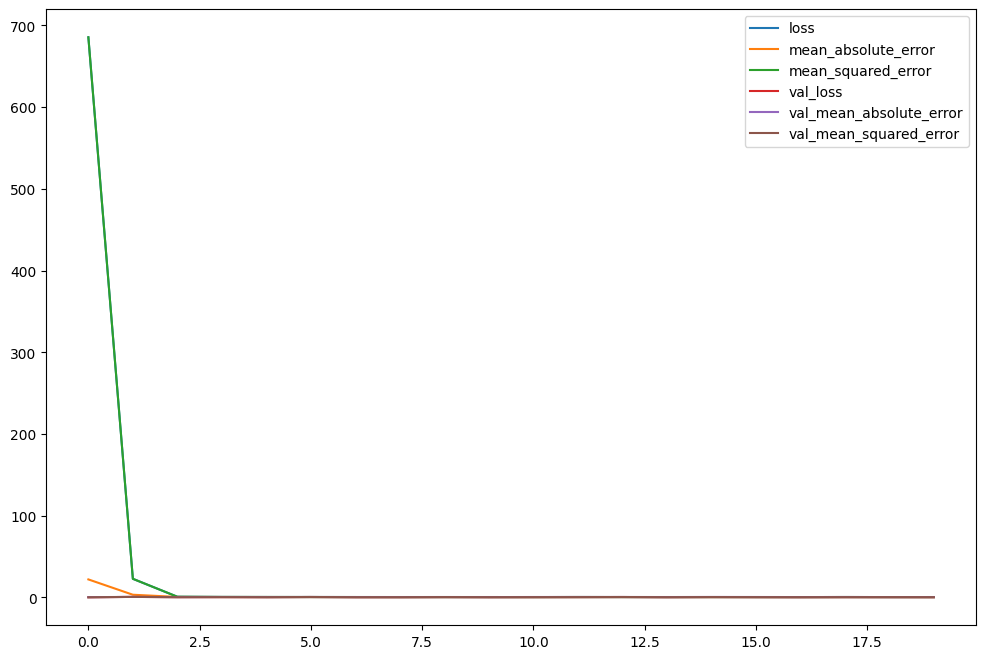

In [37]:
pd.DataFrame(history.history).plot(figsize=(12,8))

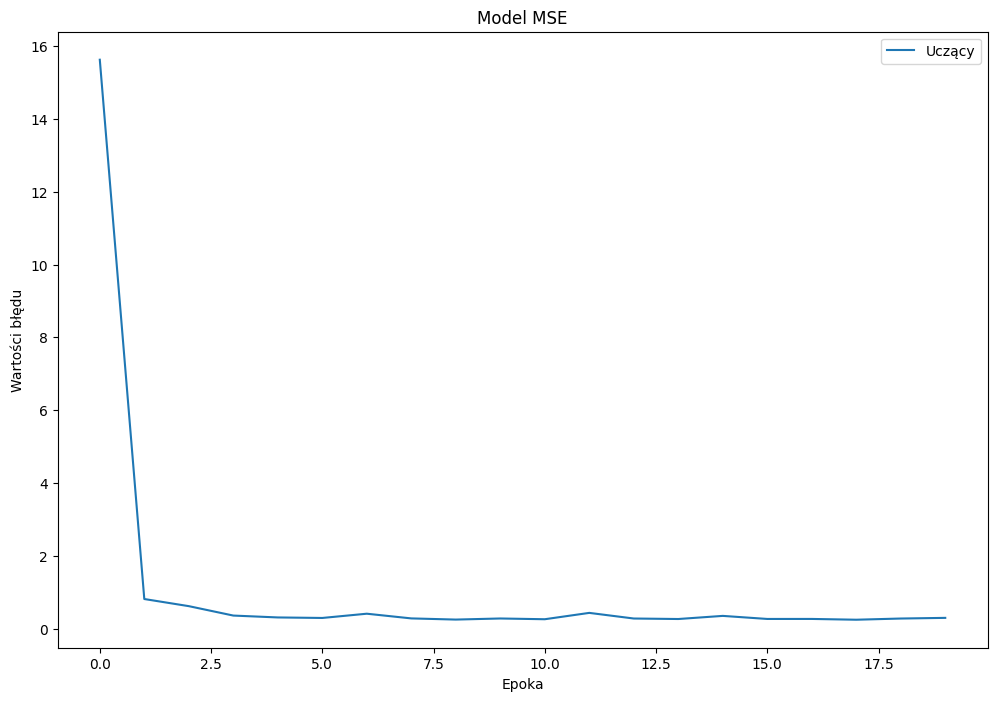

In [ ]:
plt.figure(figsize=(12,8))
# plt.plot(history.history['mean_squared_error'][2:])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model MSE')
plt.ylabel('Wartości błędu')
plt.xlabel('Epoka')
plt.legend(['Uczący', 'Walidacyjny'])

#plt.boxplot(history.history['val_mean_squared_error'])
# plt.boxplot(history.history['mean_squared_error'])

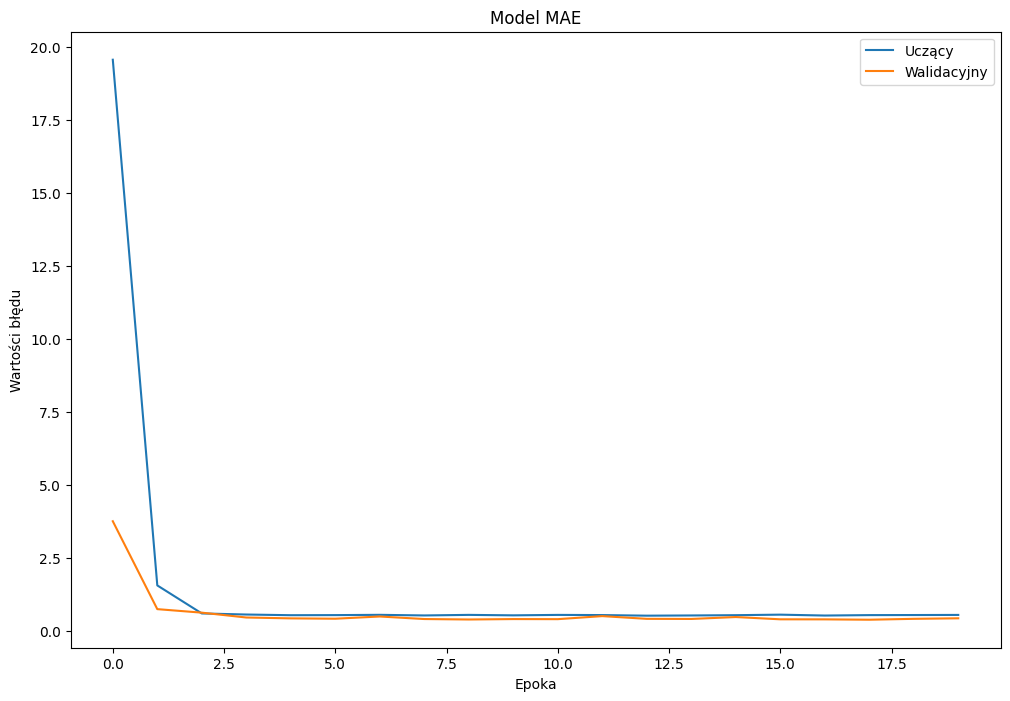

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model MAE')
plt.ylabel('Wartości błędu')
plt.xlabel('Epoka')
plt.legend(['Uczący', 'Walidacyjny'])

Text(0.5, 0, 'Epoka')

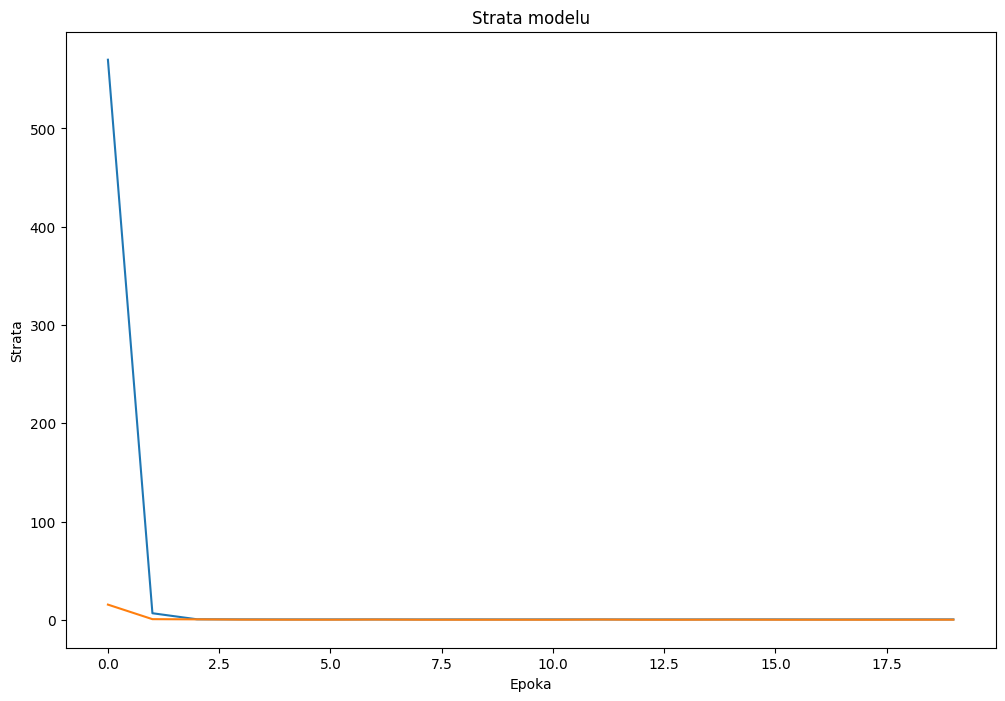

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.title('Strata modelu')
plt.ylabel('Strata')
plt.xlabel('Epoka')

Text(0.5, 0, 'Epoka')

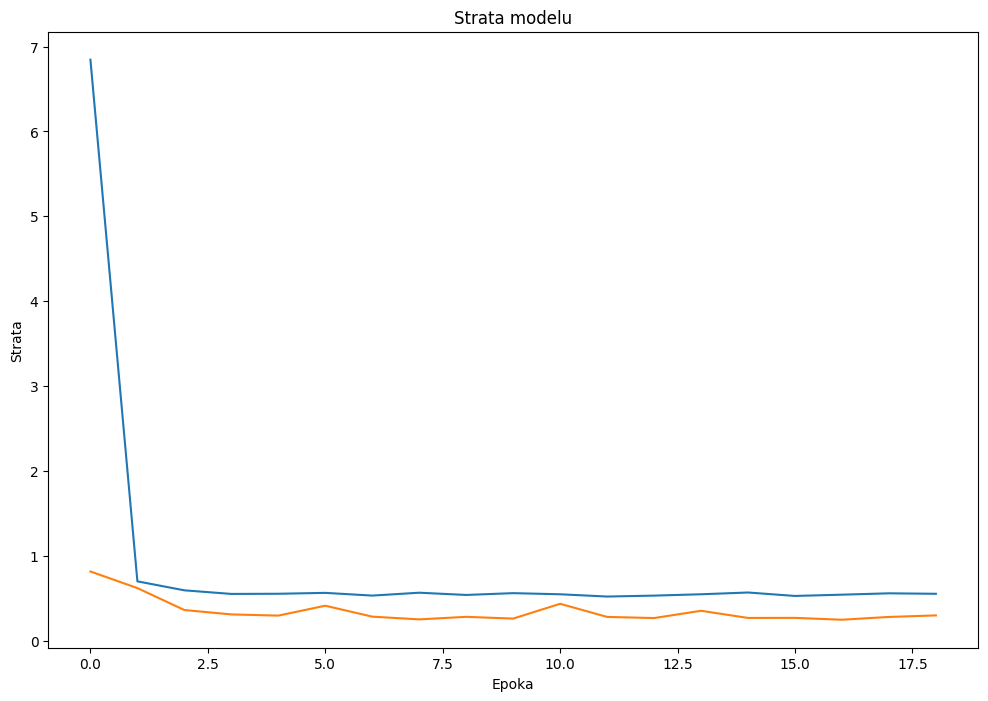

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'][1:], label="training loss")
plt.plot(history.history['val_loss'][1:], label="validation loss")
plt.title('Strata modelu')
plt.ylabel('Strata')
plt.xlabel('Epoka')

## Błędy

In [39]:
test_mse_errors = calculate_mse(y_test, test_predictions)
train_mse_errors = calculate_mse(y_train, train_predictions)
val_mse_errors = calculate_mse(y_val, val_predictions)

In [40]:
train_mae_errors = calculate_mae(y_train, train_predictions)
val_mae_errors = calculate_mae(y_val, val_predictions)
test_mae_errors = calculate_mae(y_test, test_predictions)

In [41]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
val_mse = mean_squared_error(y_val, val_predictions)

train_mse, val_mse, test_mse

(0.5269312, 0.40351763, 4.1429653)

In [42]:
from sklearn.metrics import mean_absolute_error

train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
val_mae = mean_absolute_error(y_val, val_predictions)

train_mae, val_mae, test_mae

(0.5330532, 0.55410874, 1.4257317)

In [43]:
from sklearn.metrics import mean_absolute_percentage_error

train_mape = mean_absolute_percentage_error(y_train, train_predictions)
test_mape = mean_absolute_percentage_error(y_test, test_predictions)
val_mape = mean_absolute_percentage_error(y_val, val_predictions)

train_mape, val_mape, test_mape

(0.015348279, 0.016157018, 0.035638202)

## Wykresy błędów

### MSE

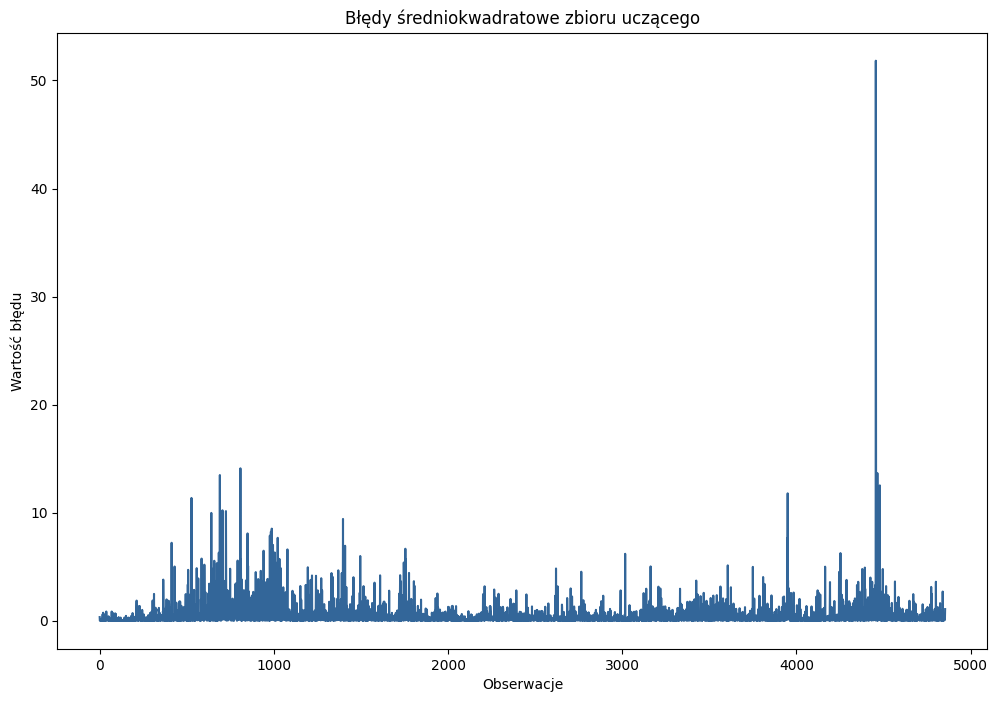

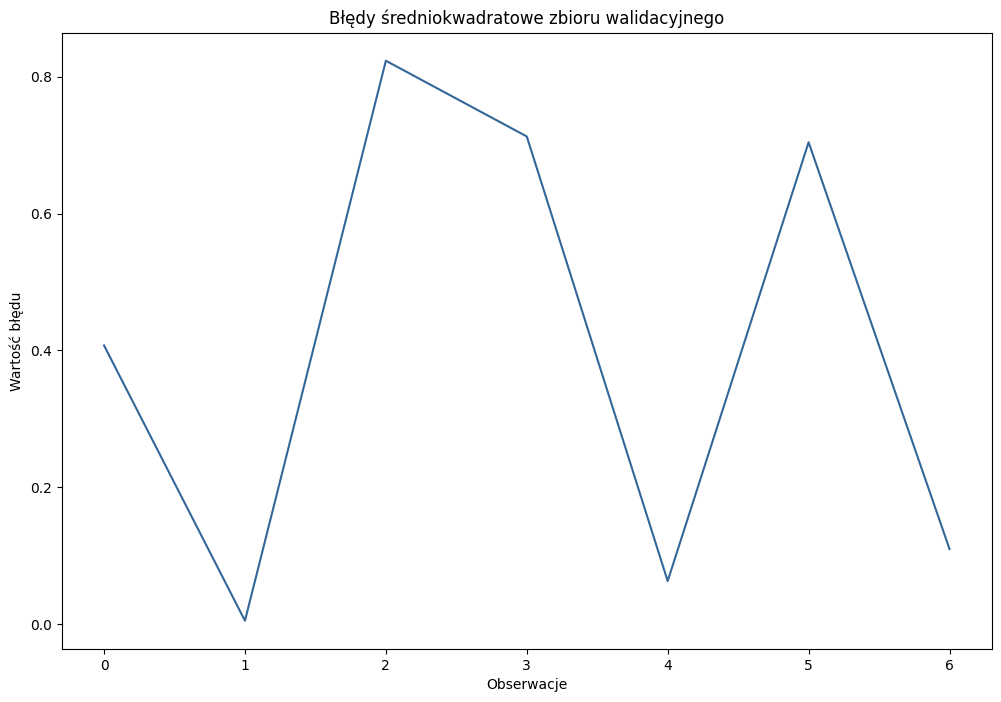

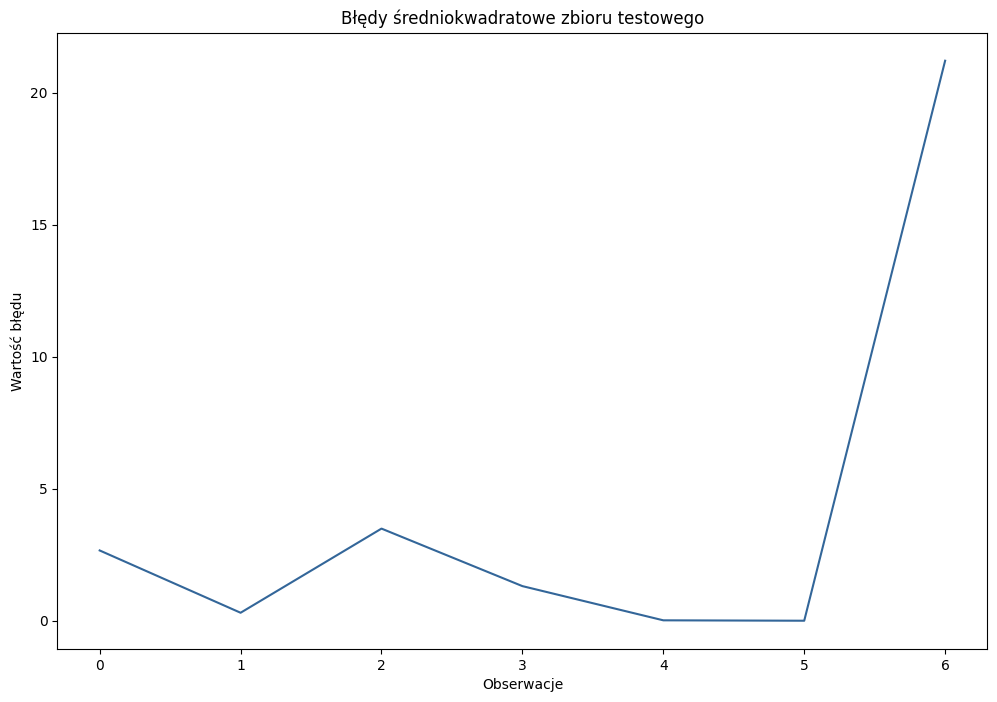

In [44]:
display_error_figure(train_mse_errors, 'Błędy średniokwadratowe zbioru uczącego')
print('')
display_error_figure(val_mse_errors, 'Błędy średniokwadratowe zbioru walidacyjnego')
print('')
display_error_figure(test_mse_errors, 'Błędy średniokwadratowe zbioru testowego')

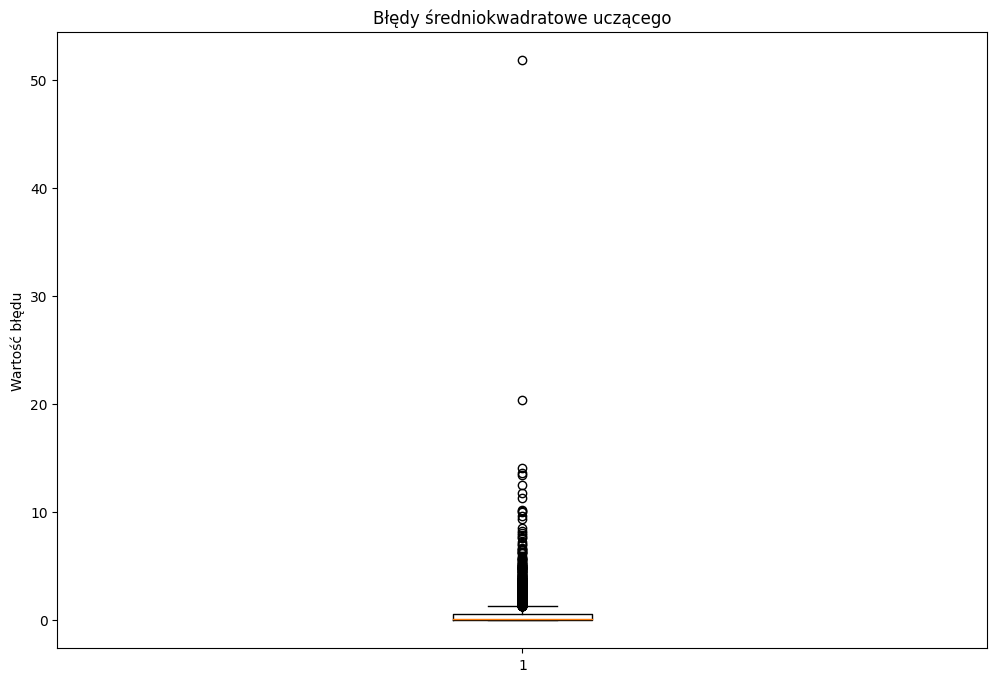

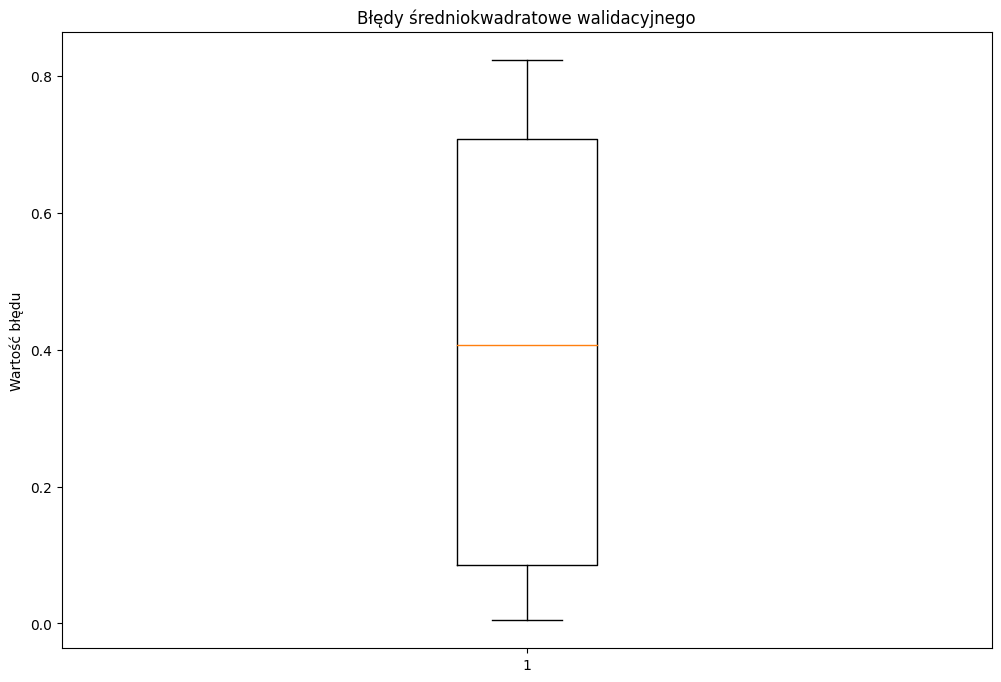

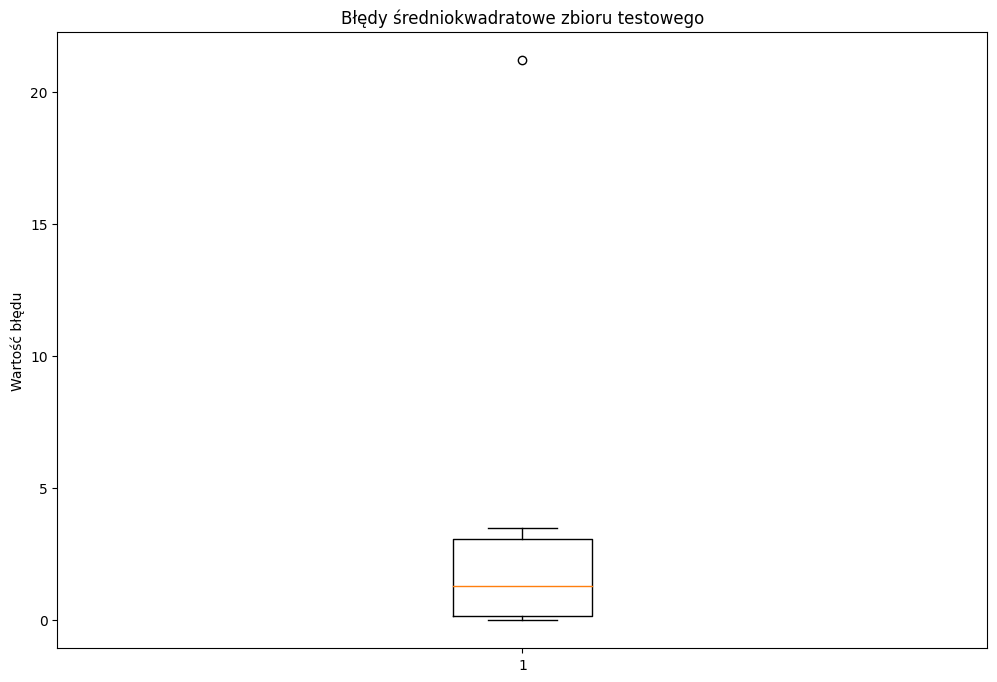

In [45]:
display_error_boxplot(train_mse_errors, 'Błędy średniokwadratowe uczącego')
print()
display_error_boxplot(val_mse_errors, 'Błędy średniokwadratowe walidacyjnego')
print()
display_error_boxplot(test_mse_errors, 'Błędy średniokwadratowe zbioru testowego')

### MAE

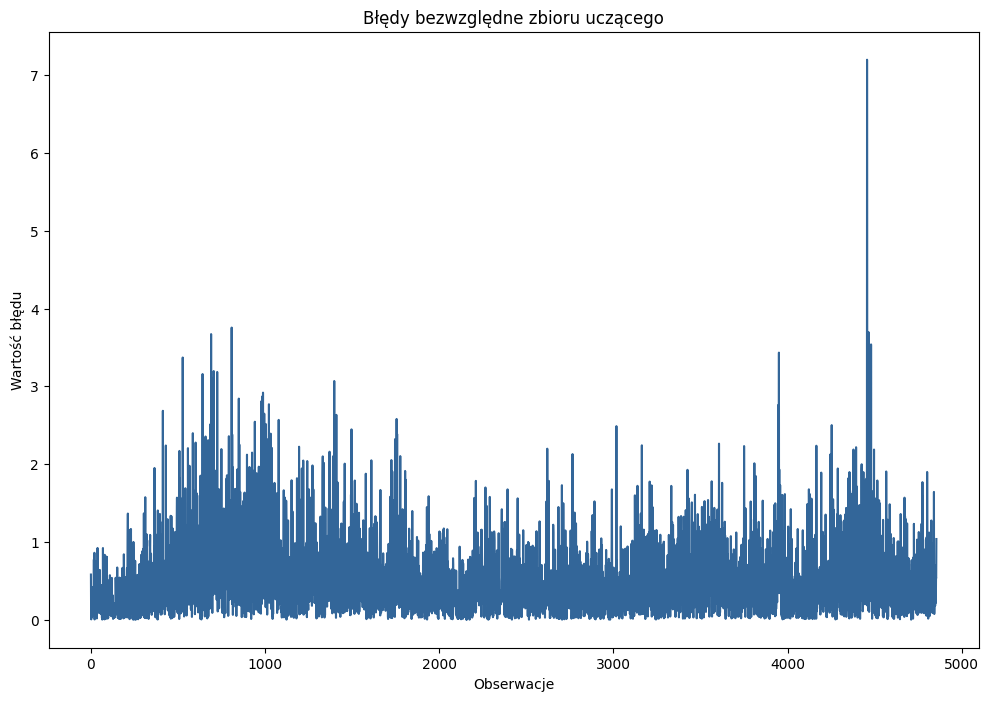

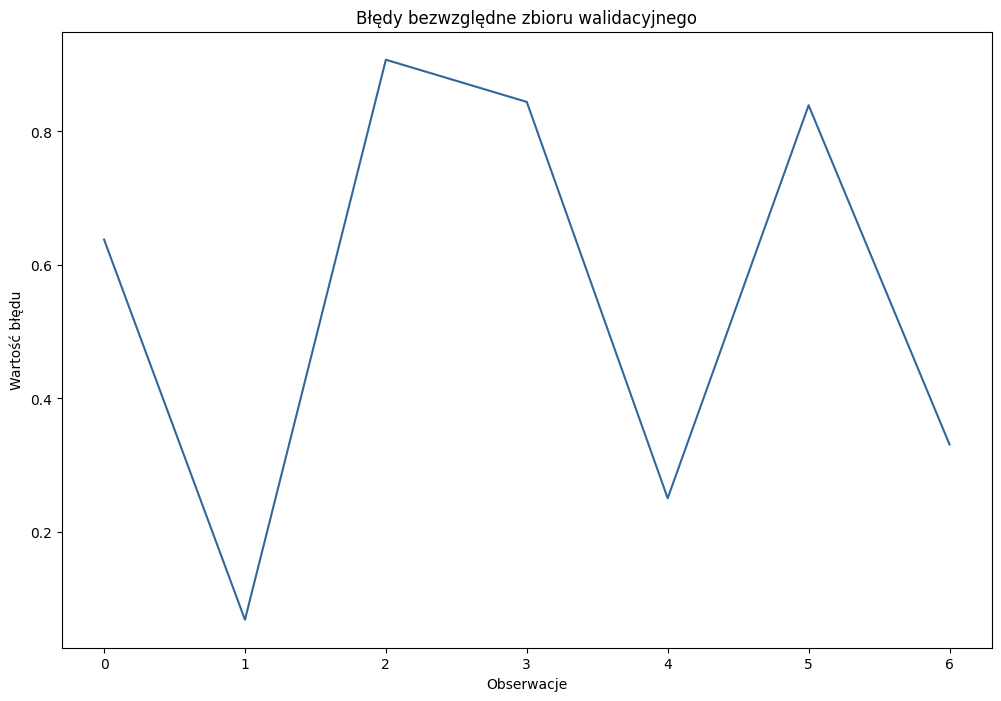

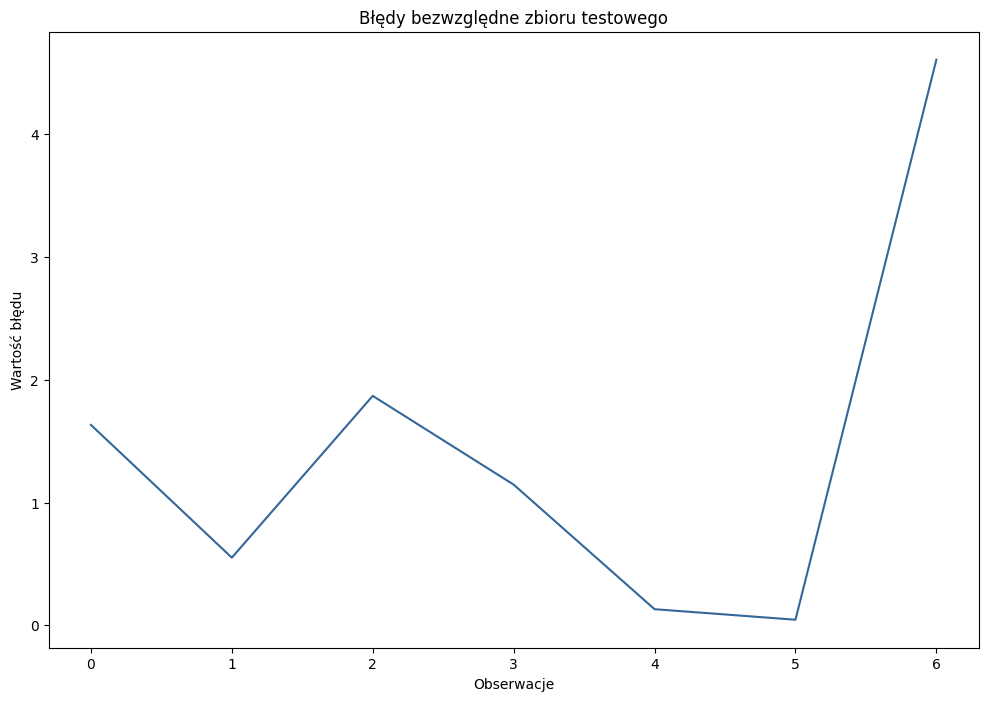

In [46]:
display_error_figure(train_mae_errors, 'Błędy bezwzględne zbioru uczącego')
print()
display_error_figure(val_mae_errors, 'Błędy bezwzględne zbioru walidacyjnego')
print()
display_error_figure(test_mae_errors, 'Błędy bezwzględne zbioru testowego')

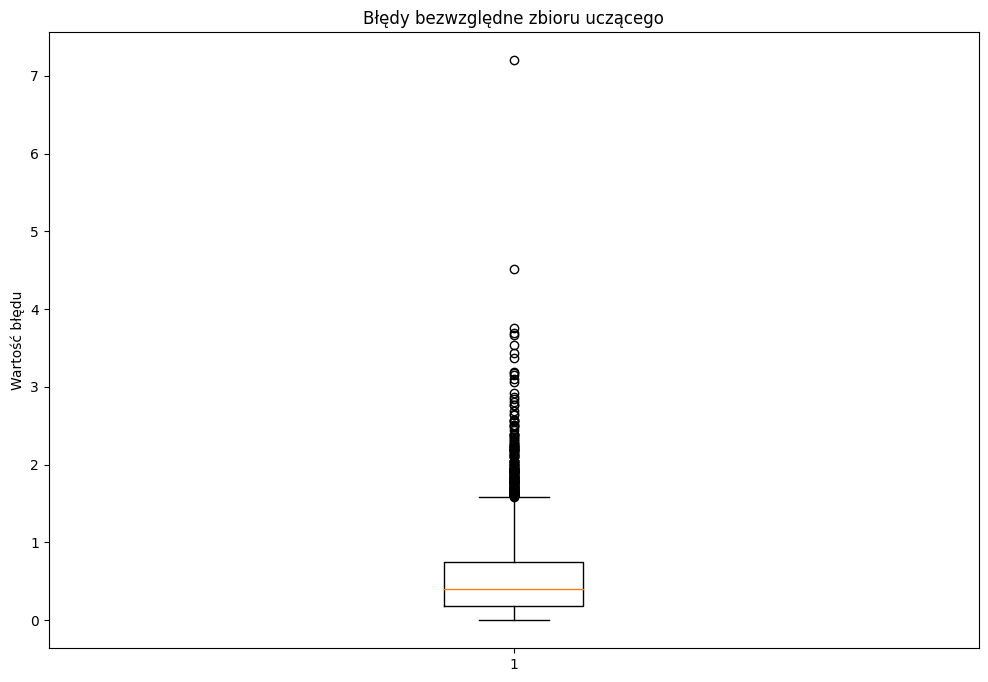

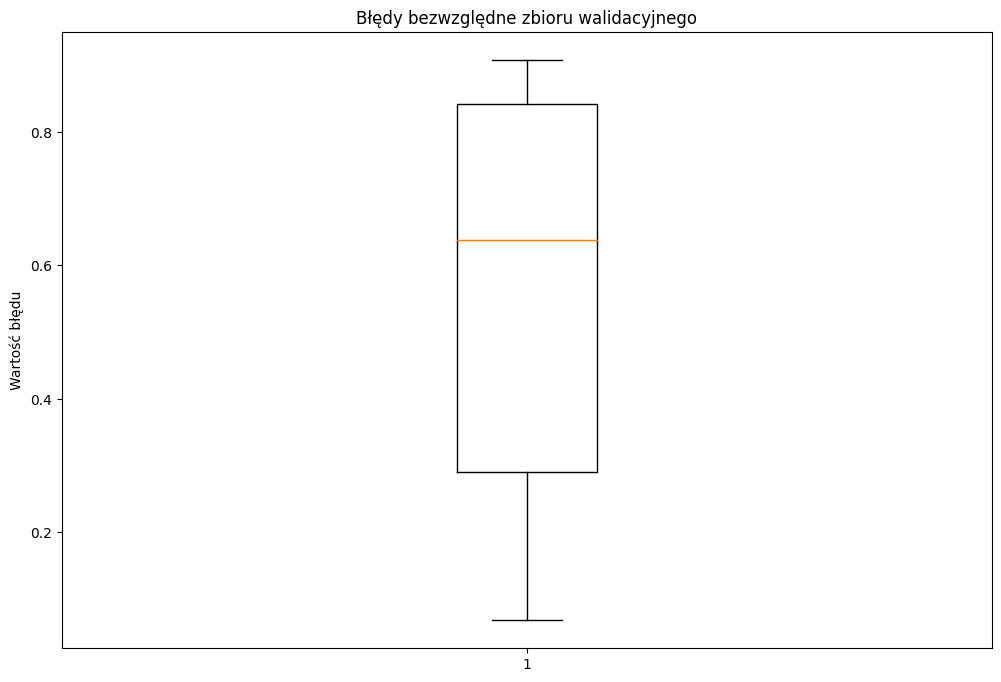

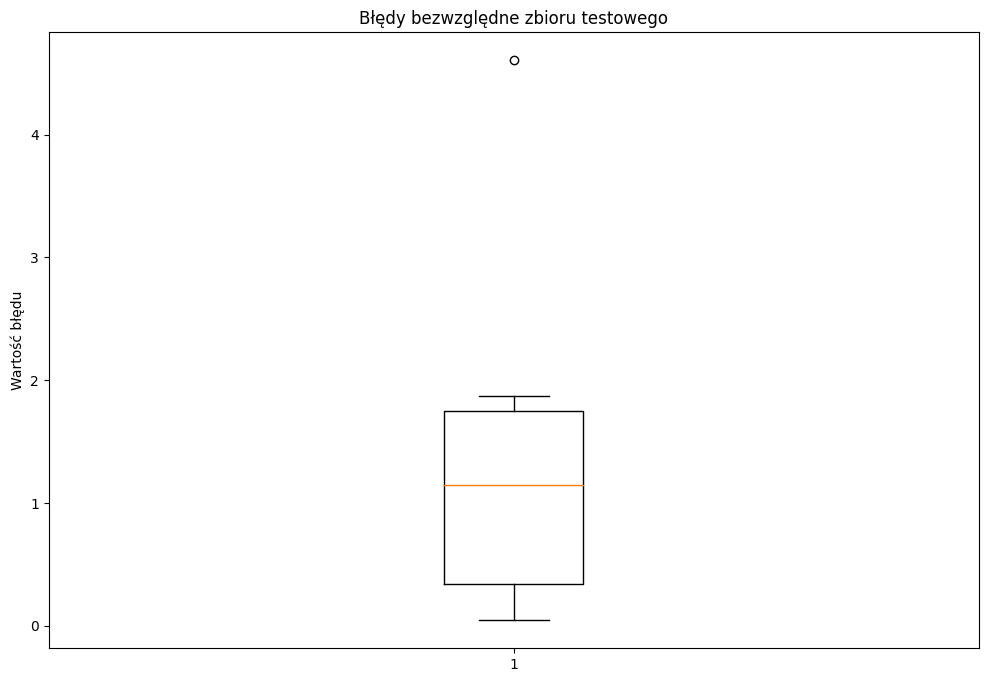

In [47]:
display_error_boxplot(train_mae_errors, 'Błędy bezwzględne zbioru uczącego')
print()
display_error_boxplot(val_mae_errors, 'Błędy bezwzględne zbioru walidacyjnego')
print()
display_error_boxplot(test_mae_errors, 'Błędy bezwzględne zbioru testowego')

## Wykresy przewidywanych wartości

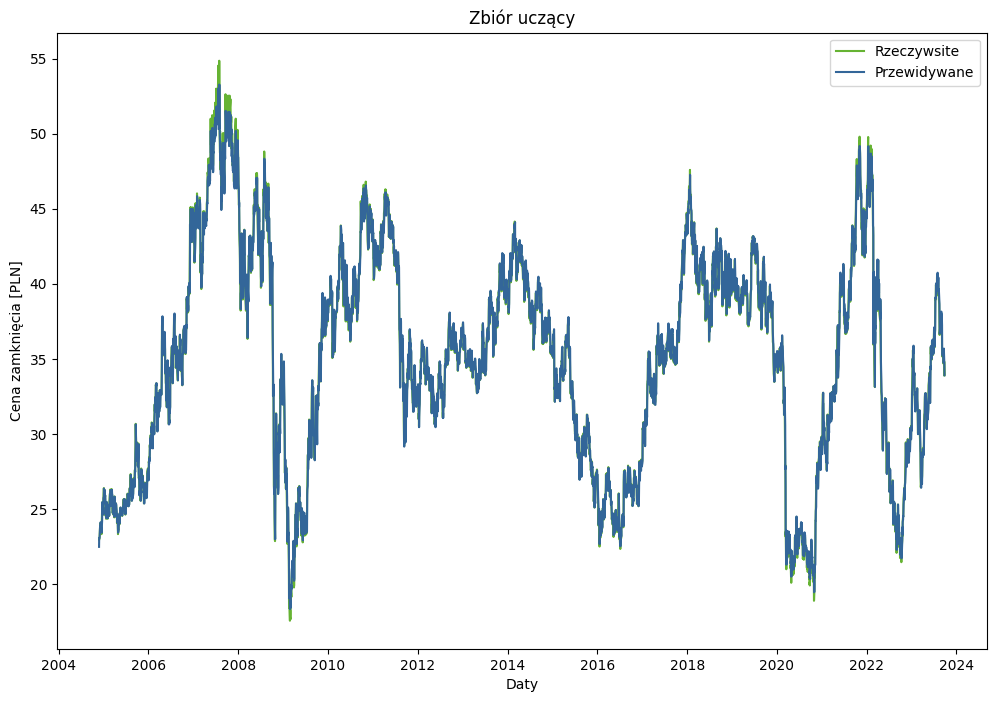

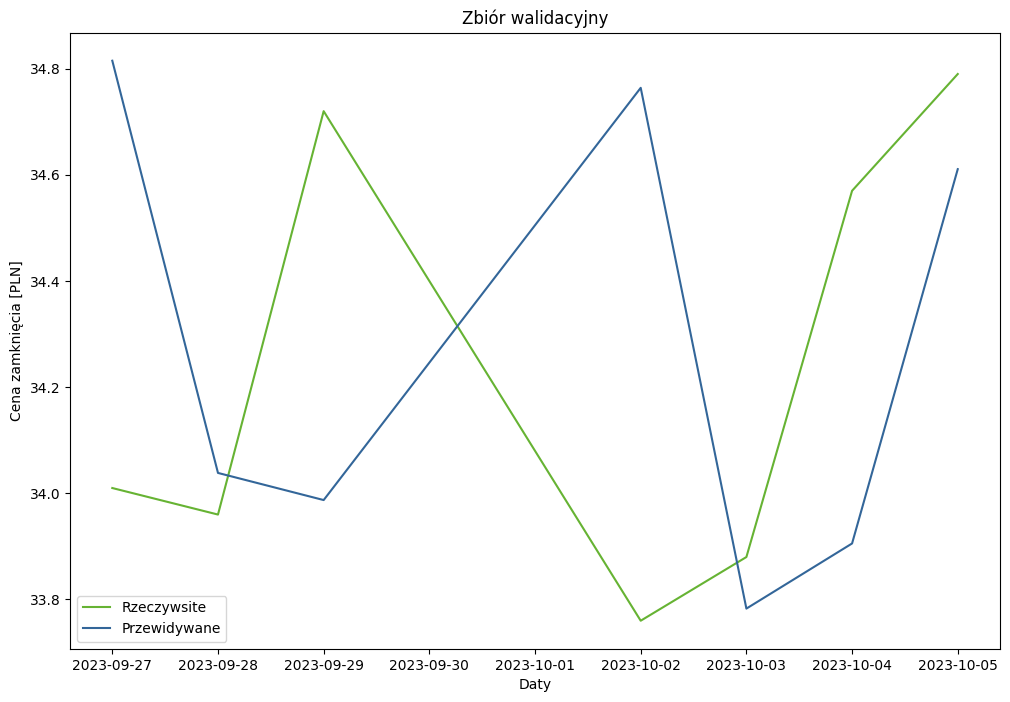

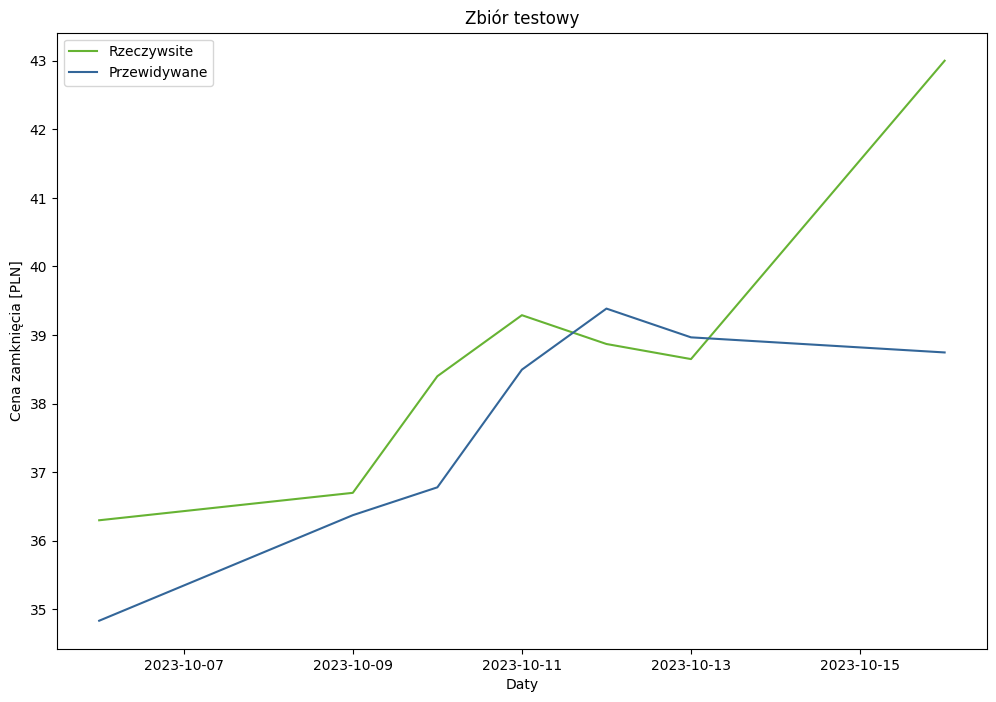

In [88]:
display_prediction_data(dates_train, train_predictions, y_train, 'Zbiór uczący')
print()
display_prediction_data(dates_val, val_predictions, y_val, 'Zbiór walidacyjny')
print()
display_prediction_data(dates_test, test_predictions, y_test, 'Zbiór testowy')

Text(0.5, 1.0, 'Observations vs Predictions')

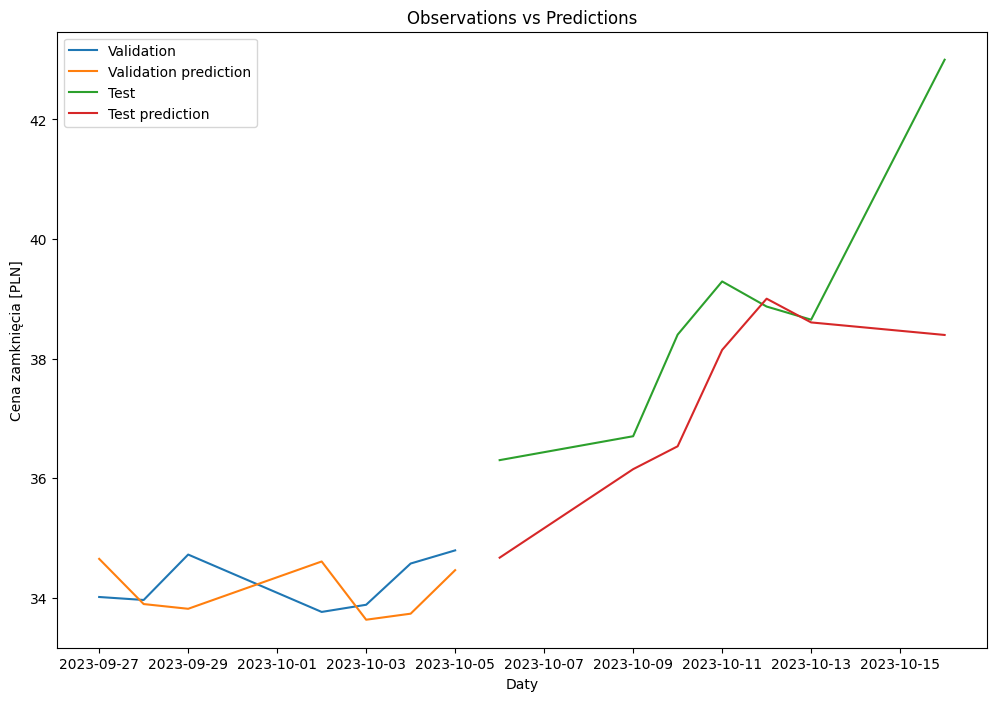

In [49]:
plt.figure(figsize=(12,8))
# plt.plot(dates_train, y_train)
# plt.plot(dates_train, train_predictions)

plt.plot(dates_val, y_val)
plt.plot(dates_val, val_predictions)

plt.plot(dates_test, y_test)
plt.plot(dates_test, test_predictions)

plt.xlabel('Daty')
plt.ylabel('Cena zamknięcia [PLN]')

# plt.legend(['Train', 'Train prediction',  'Validation', 'Validation prediction', 'Test', 'Test prediction'])
plt.legend(['Validation', 'Validation prediction', 'Test', 'Test prediction'])
plt.title('Observations vs Predictions')

# ARIMA

In [ ]:
pip install pmdarima

In [ ]:
from pmdarima.arima import auto_arima

model_arima = auto_arima(y=y_train,
                    # start_p=0,
                    # start_q=0,
                    # test='adf',
                    # max_p=5,
                    # max_q=5,
                    m=6,
                    # d=None,
                    # start_P=0,
                    D=1,
                    trace=True,
                    seasonal=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[6] intercept   : AIC=inf, Time=43.44 sec
 ARIMA(0,0,0)(0,1,0)[6] intercept   : AIC=15568.372, Time=0.14 sec
 ARIMA(1,0,0)(1,1,0)[6] intercept   : AIC=10064.176, Time=3.49 sec
 ARIMA(0,0,1)(0,1,1)[6] intercept   : AIC=12529.568, Time=2.92 sec
 ARIMA(0,0,0)(0,1,0)[6]             : AIC=15566.454, Time=0.13 sec
 ARIMA(1,0,0)(0,1,0)[6] intercept   : AIC=11212.265, Time=0.61 sec
 ARIMA(1,0,0)(2,1,0)[6] intercept   : AIC=9674.951, Time=11.44 sec
 ARIMA(1,0,0)(2,1,1)[6] intercept   : AIC=inf, Time=23.73 sec
 ARIMA(1,0,0)(1,1,1)[6] intercept   : AIC=inf, Time=13.35 sec
 ARIMA(0,0,0)(2,1,0)[6] intercept   : AIC=15543.509, Time=2.20 sec
 ARIMA(2,0,0)(2,1,0)[6] intercept   : AIC=9674.866, Time=11.38 sec
 ARIMA(2,0,0)(1,1,0)[6] intercept   : AIC=10056.150, Time=4.58 sec
 ARIMA(2,0,0)(2,1,1)[6] intercept   : AIC=inf, Time=36.14 sec
 ARIMA(2,0,0)(1,1,1)[6] intercept   : AIC=inf, Time=17.05 sec
 ARIMA(3,0,0)(2,1,0)[6] intercept   : AIC=96

In [ ]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 4146
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 6)   Log Likelihood               -4831.439
Date:                            Tue, 02 Jan 2024   AIC                           9672.878
Time:                                    17:32:13   BIC                           9704.520
Sample:                                         0   HQIC                          9684.075
                                           - 4146                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9053      0.005    169.739      0.000       0.895       0.916
ma.L1          0.0248      0.014      1.755      0.079      -0.003       0.052
ar.S.L6       -0.6679      0.012    -57.708      0.000      -0.691      -0.645
ar.S.L12      -0.3046      0.012    -25.587      0.000      -0.328      -0.281
sigma2         0.6036      0.010     63.136      0.000       0.585       0.622
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               654.45
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
y_train.shape
X_train.reshape(-1,1)

array([[22.77989 ],
       [22.965849],
       [22.87287 ],
       ...,
       [28.04    ],
       [27.98    ],
       [26.4     ]], dtype=float32)

In [ ]:
X_train = X_train[:,:,-1]
X_val = X_val[:,:,-1]
X_test = X_test[:,:,-1]

In [ ]:
model_arima.fit(y=y_train, X=X_train)

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(2, 1, 0, 6),
      suppress_warnings=True, with_intercept=False)

In [ ]:
train_forecast = model_arima.predict(X=X_train, n_periods=len(X_train)).flatten()
validation_forecast = model_arima.predict(X=X_val, n_periods=len(X_val)).flatten()
test_forecast = model_arima.predict(X=X_test, n_periods=len(X_test)).flatten()

## Błędy

In [ ]:
arima_train_mae_errors = calculate_mae(y_train, train_forecast)
arima_val_mae_errors = calculate_mae(y_val, validation_forecast)
arima_test_mae_errors = calculate_mae(y_test, test_forecast)

In [ ]:
arima_train_mse_errors = calculate_mse(y_train, train_predictions)
arima_val_mse_errors = calculate_mse(y_val, validation_forecast)
arima_test_mse_errors = calculate_mse(y_test, test_forecast)

In [ ]:
from sklearn.metrics import mean_squared_error

arima_train_mse = mean_squared_error(y_train, train_forecast)
arima_val_mse = mean_squared_error(y_val, validation_forecast)
arima_test_mse = mean_squared_error(y_test, test_forecast)


arima_train_mse, arima_val_mse, arima_test_mse

(1.5388297563696283, 2.300629238785262, 0.909593371220387)

In [ ]:
from sklearn.metrics import mean_absolute_error

arima_train_mae = mean_absolute_error(y_train, train_forecast)
arima_val_mae = mean_absolute_error(y_val, validation_forecast)
arima_test_mae = mean_absolute_error(y_test, test_forecast)


arima_train_mae, arima_val_mae, arima_test_mae

(0.9889430086105515, 1.2031688471885982, 0.7459263653094903)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

arima_train_mape = mean_absolute_percentage_error(y_train, train_forecast)
arima_val_mape = mean_absolute_percentage_error(y_val, validation_forecast)
arima_test_mape = mean_absolute_percentage_error(y_test, test_forecast)

arima_train_mape, arima_val_mape, arima_test_mape

(0.027416345731529273, 0.03007892861978339, 0.024238880961150566)

### MSE

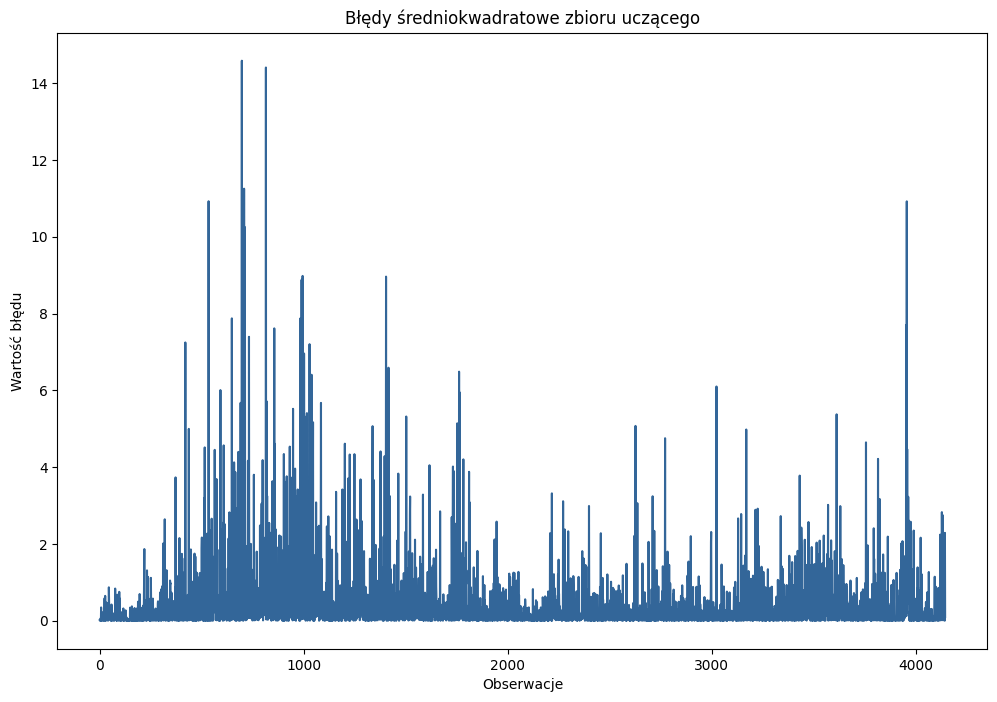

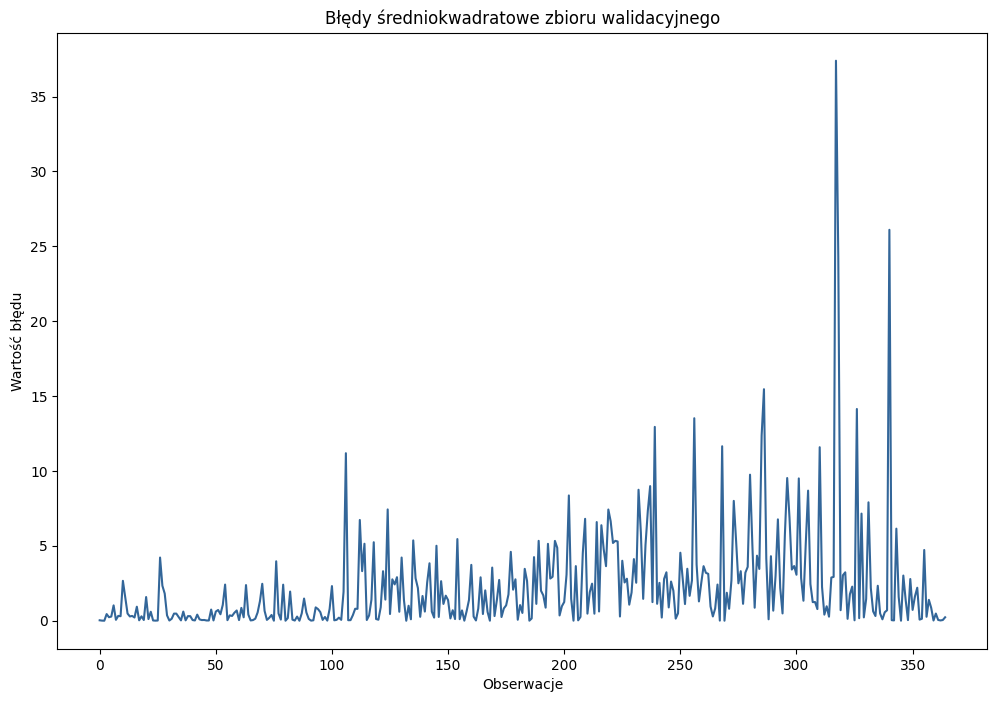

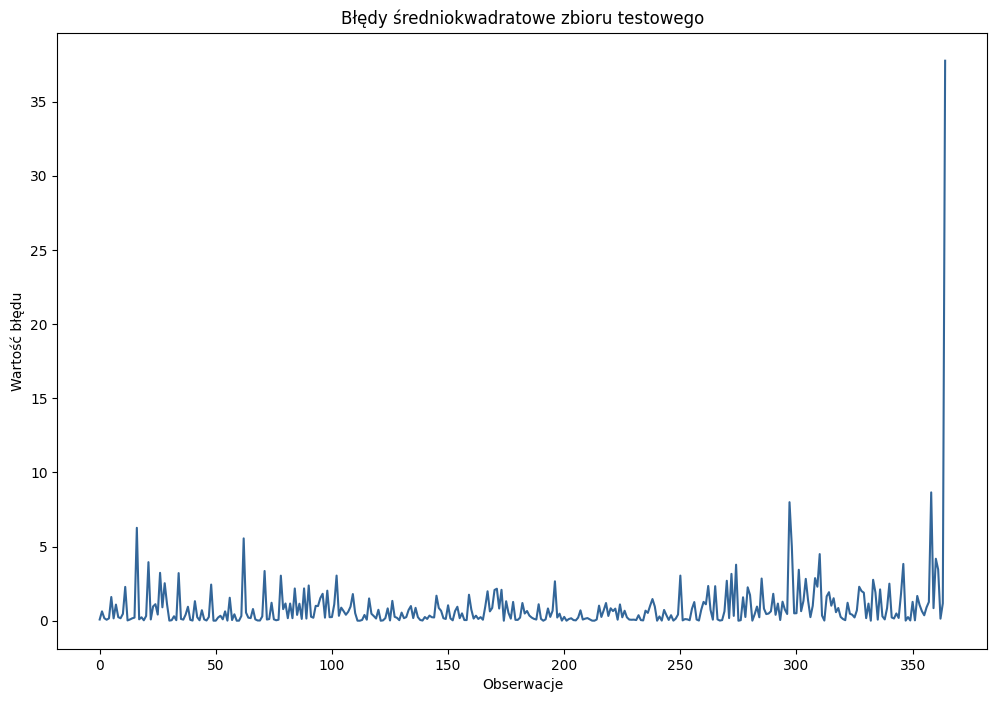

In [ ]:
display_error_figure(arima_train_mse_errors, 'Błędy średniokwadratowe zbioru uczącego')
print('')
display_error_figure(arima_val_mse_errors, 'Błędy średniokwadratowe zbioru walidacyjnego')
print('')
display_error_figure(arima_test_mse_errors, 'Błędy średniokwadratowe zbioru testowego')

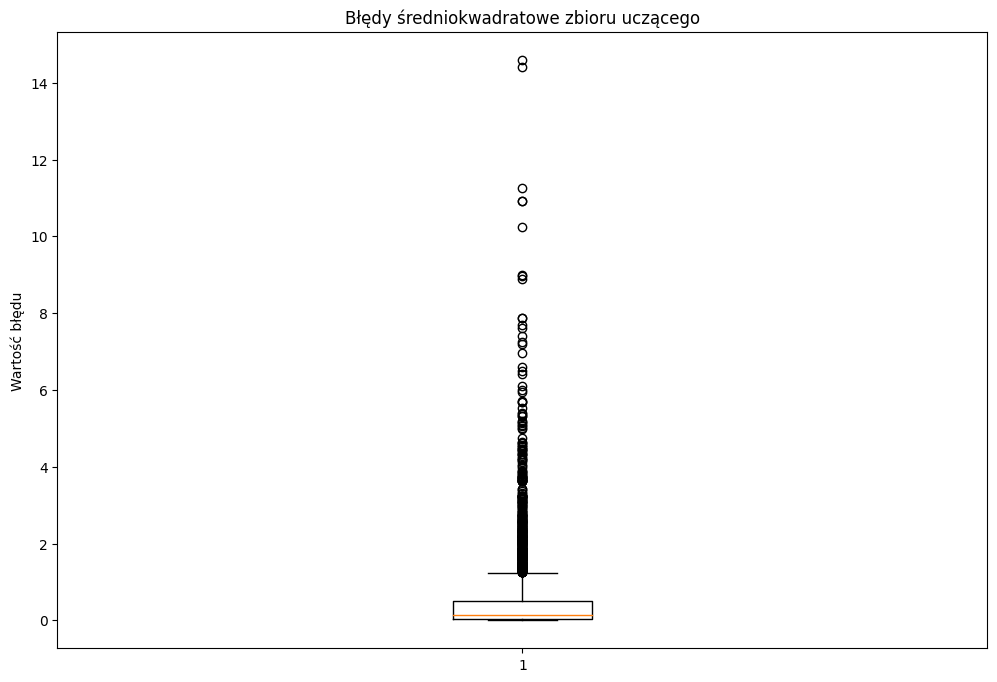

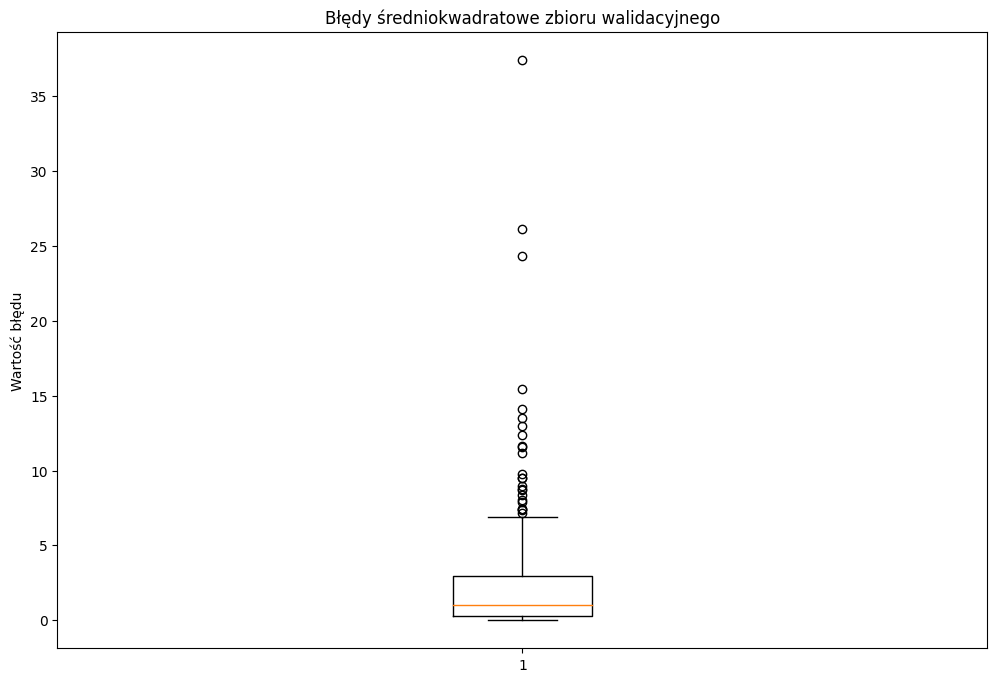

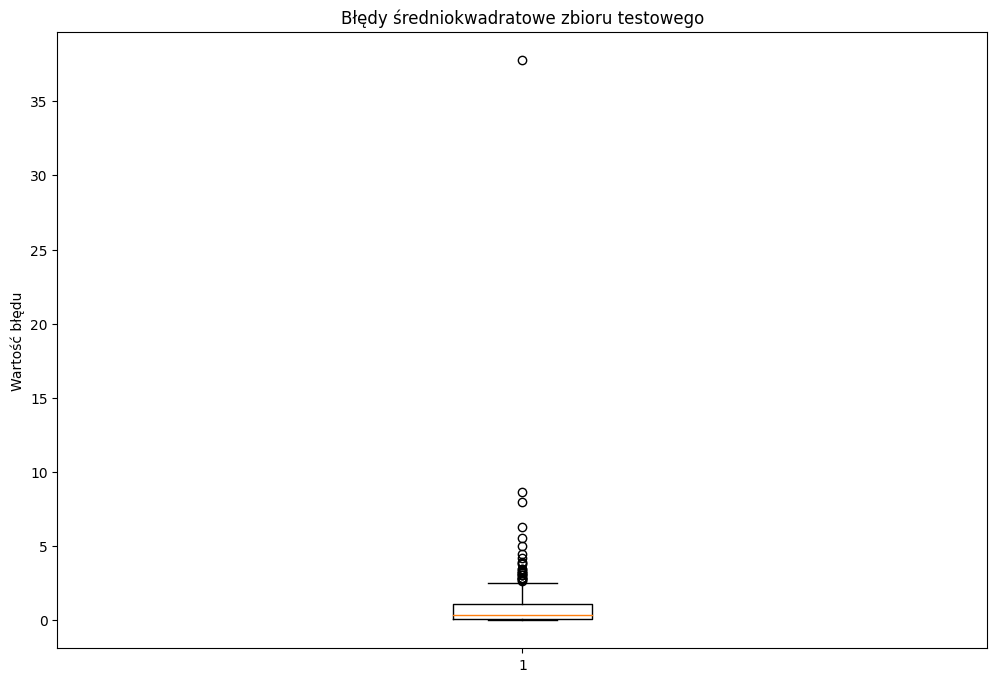

In [ ]:
display_error_boxplot(arima_train_mse_errors, 'Błędy średniokwadratowe zbioru uczącego')
print()
display_error_boxplot(arima_val_mse_errors, 'Błędy średniokwadratowe zbioru walidacyjnego')
print()
display_error_boxplot(arima_test_mse_errors, 'Błędy średniokwadratowe zbioru testowego')

### MAE

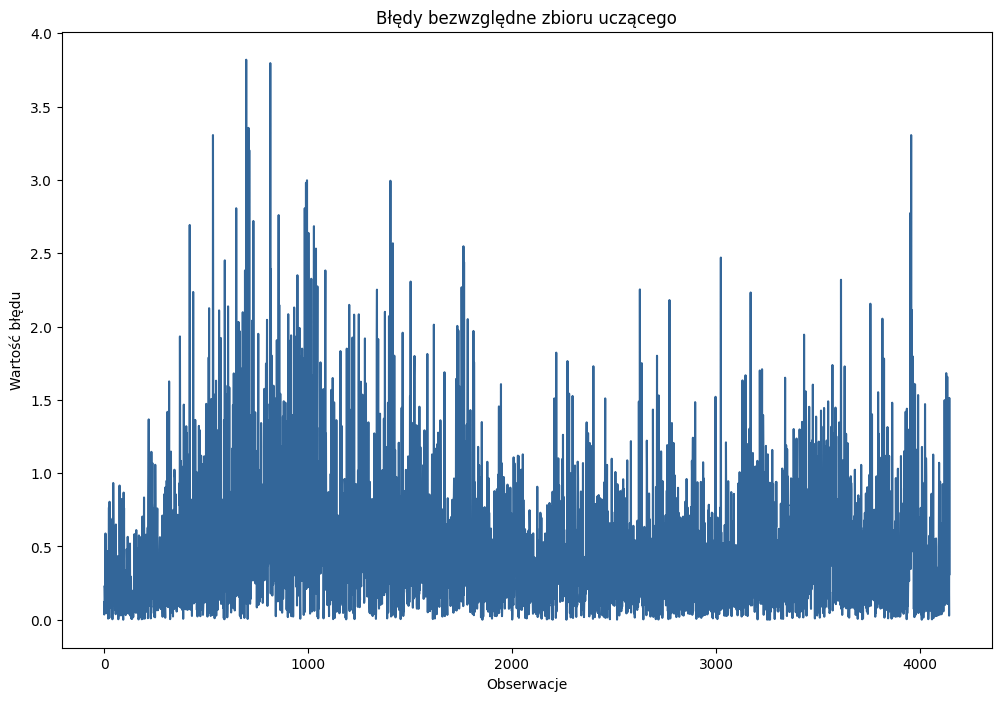

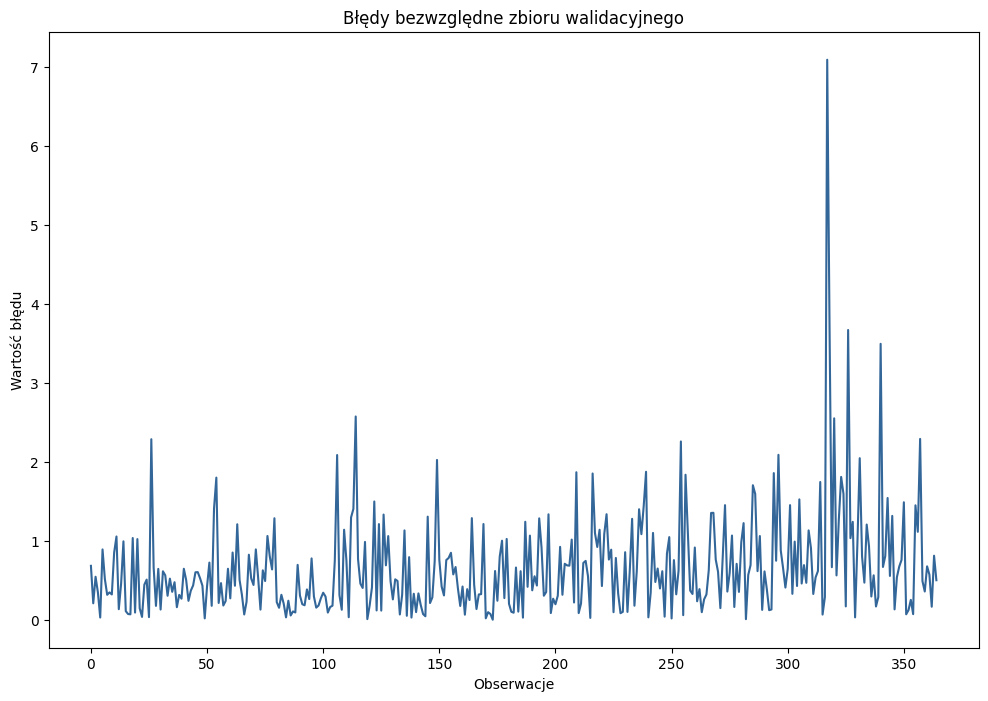

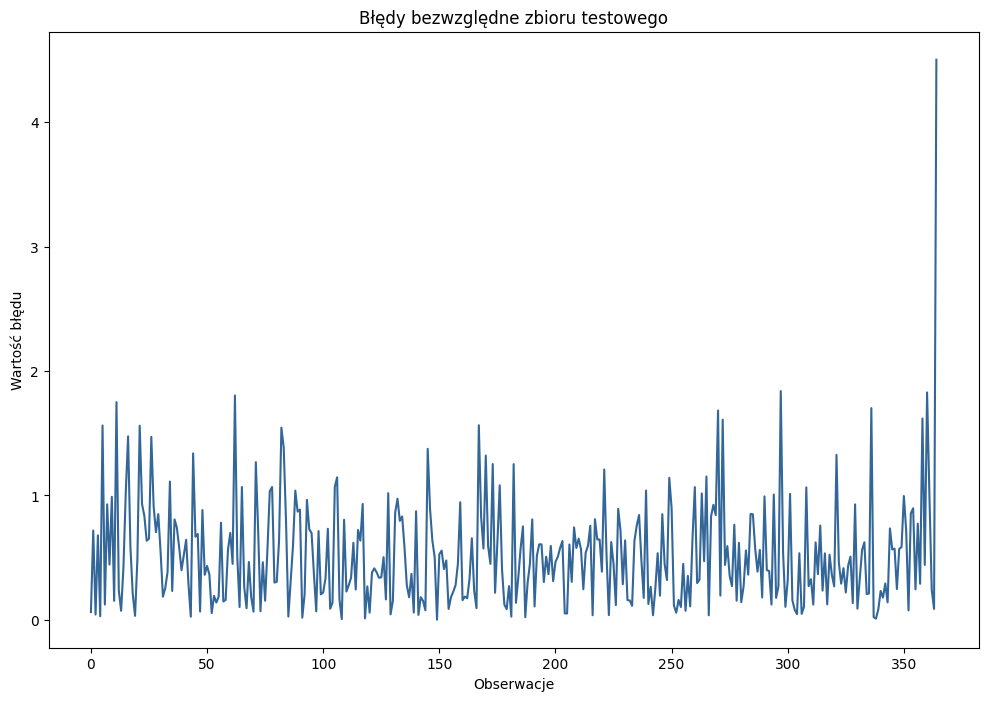

In [ ]:
display_error_figure(train_mae_errors, 'Błędy bezwzględne zbioru uczącego')
print()
display_error_figure(val_mae_errors, 'Błędy bezwzględne zbioru walidacyjnego')
print()
display_error_figure(test_mae_errors, 'Błędy bezwzględne zbioru testowego')

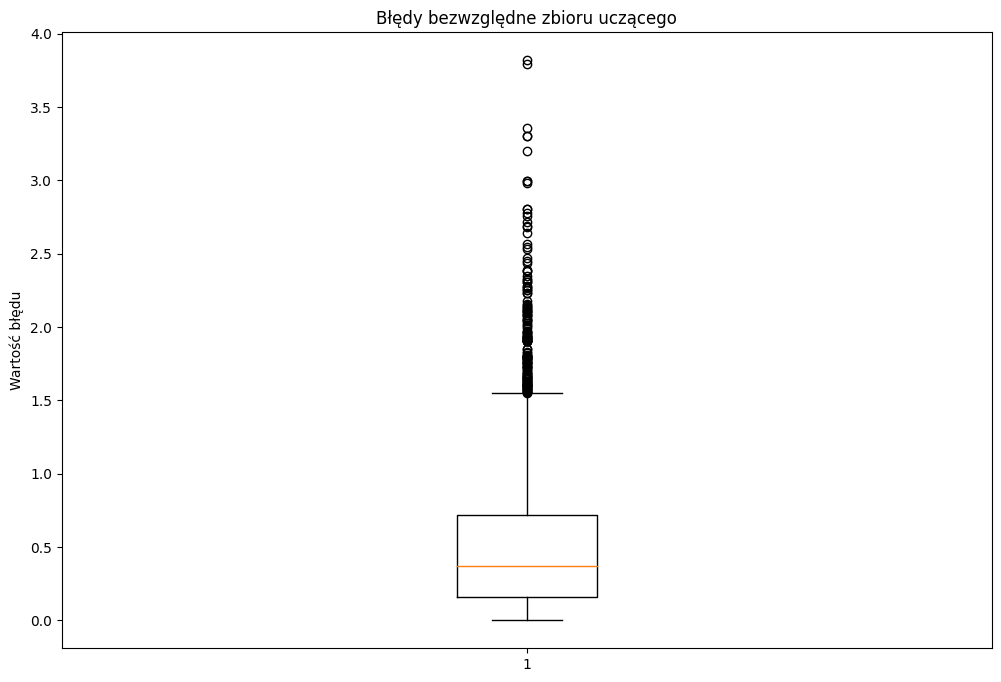

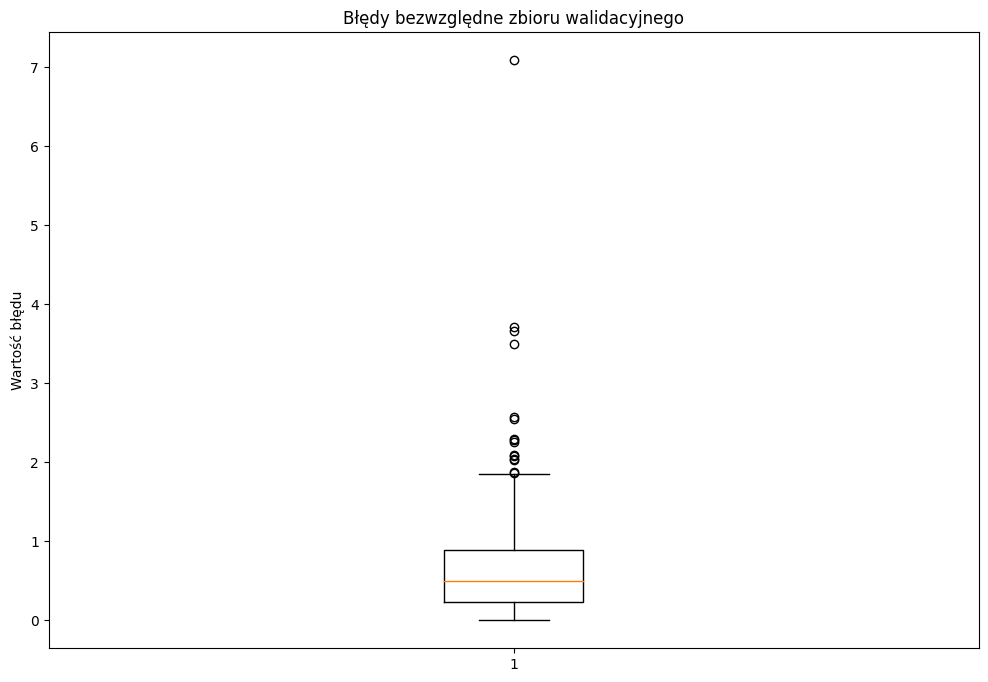

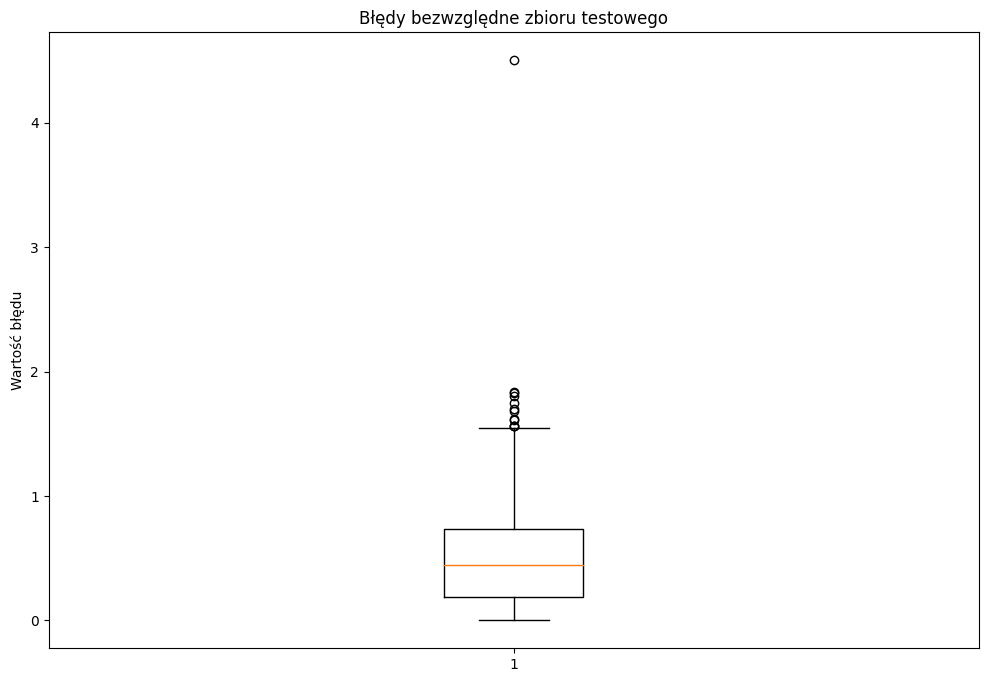

In [ ]:
display_error_boxplot(train_mae_errors, 'Błędy bezwzględne zbioru uczącego')
print()
display_error_boxplot(val_mae_errors, 'Błędy bezwzględne zbioru walidacyjnego')
print()
display_error_boxplot(test_mae_errors, 'Błędy bezwzględne zbioru testowego')

## Wykresy przewidywanych wartości

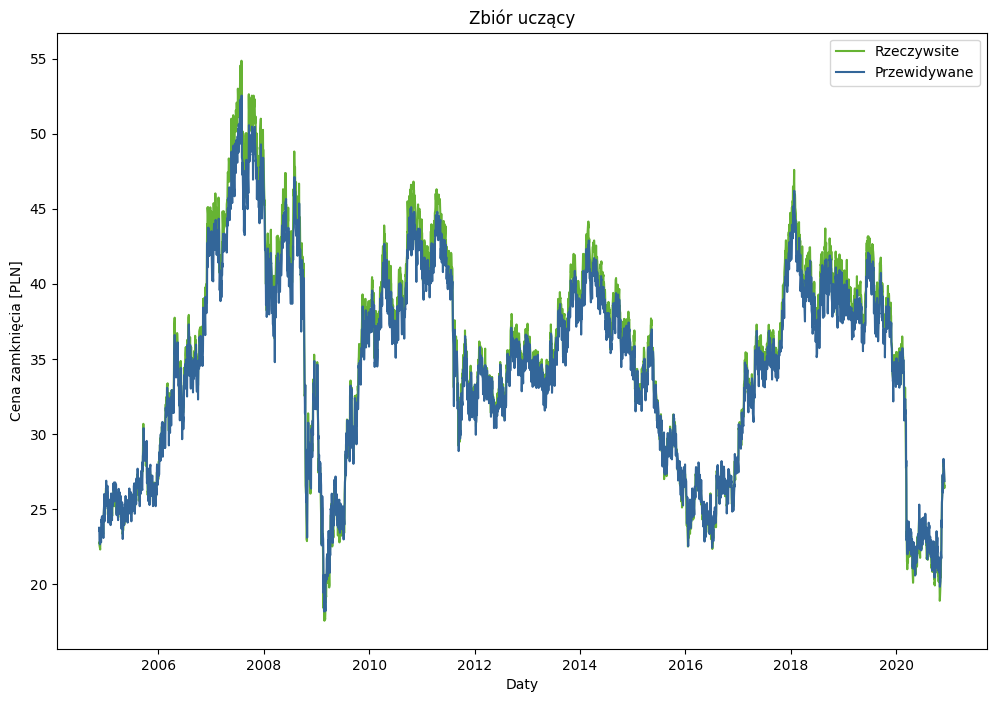

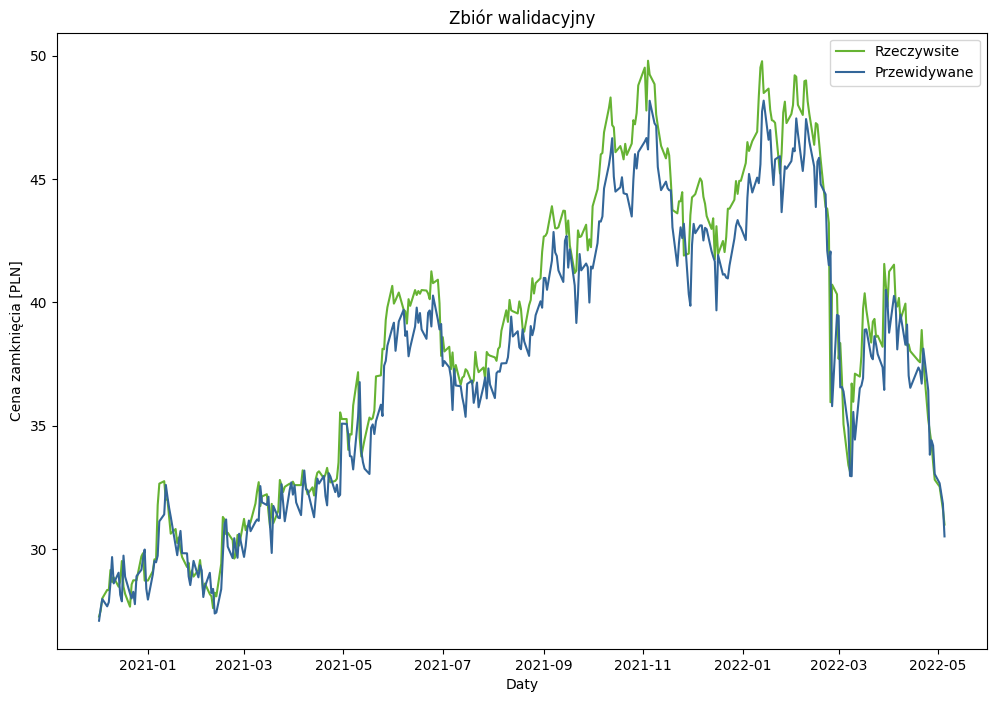

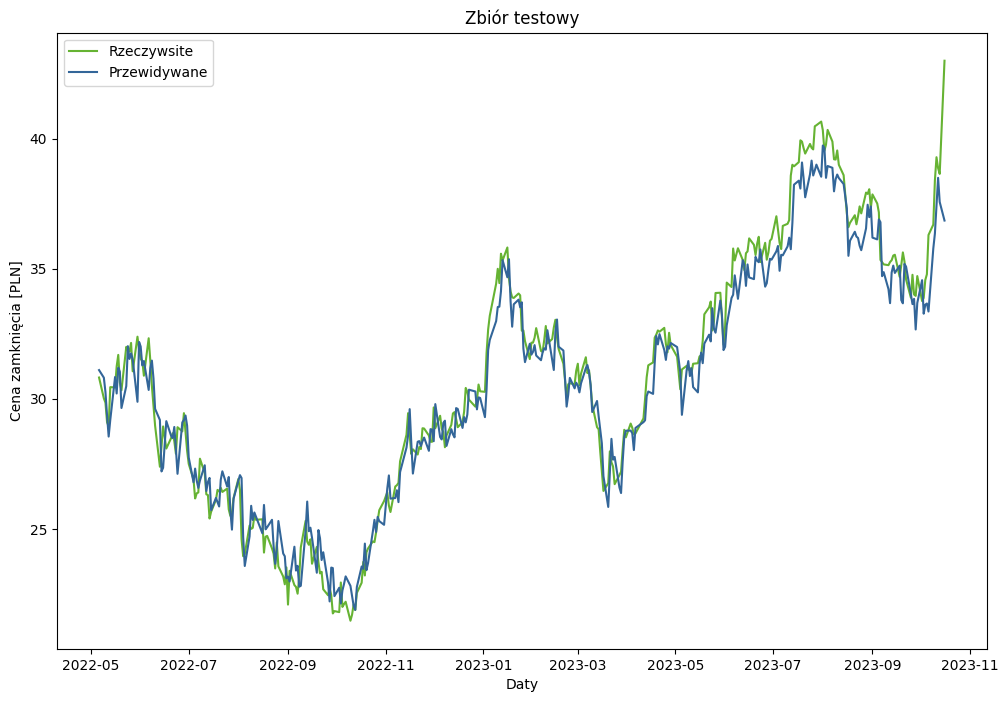

In [ ]:
display_prediction_data(dates_train, train_forecast, y_train, 'Zbiór uczący')
print()
display_prediction_data(dates_val, validation_forecast, y_val, 'Zbiór walidacyjny')
print()
display_prediction_data(dates_test, test_forecast, y_test, 'Zbiór testowy')

Text(0.5, 1.0, 'Observations vs Predictions')

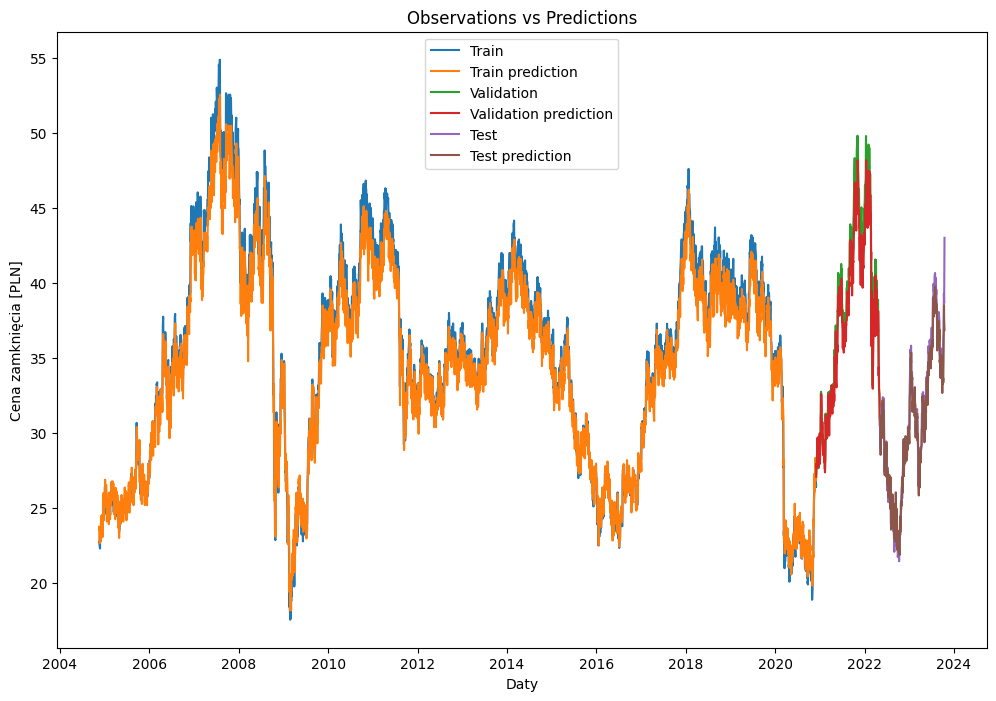

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(dates_train, y_train)
plt.plot(dates_train, train_forecast)

plt.plot(dates_val, y_val)
plt.plot(dates_val, validation_forecast)

plt.plot(dates_test, y_test)
plt.plot(dates_test, test_forecast)

plt.xlabel('Daty')
plt.ylabel('Cena zamknięcia [PLN]')

plt.legend(['Train', 'Train prediction',  'Validation', 'Validation prediction', 'Test', 'Test prediction'])
plt.title('Observations vs Predictions')